In [ ]:
# Import necessary libraries for data manipulation, visualization, and model building
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization (plots)
from sklearn.preprocessing import MinMaxScaler  # For feature scaling (normalization)
from sklearn.model_selection import train_test_split  # For splitting data into train/test sets
from sklearn.linear_model import LinearRegression  # For linear regression model
from sklearn.ensemble import RandomForestRegressor  # For random forest regression model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # For model evaluation metrics

# Import additional libraries for advanced modeling and evaluation
import xgboost as xgb  # For gradient boosting model
from sklearn.svm import SVR  # For support vector regression model
from sklearn.neighbors import KNeighborsRegressor  # For k-nearest neighbors regression model

# Import necessary libraries for Artificial Neural Networks (ANN)
from tensorflow.keras.models import Sequential  # For building sequential neural network models
from tensorflow.keras.layers import Dense, Input  # For defining layers in the neural network
from tensorflow.keras.optimizers import Adam  # For optimization in ANN training
from tensorflow.keras.callbacks import EarlyStopping  # For stopping training early based on validation performance


Load and Preprocess Data

In [ ]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the dataset.
    """
    df = pd.read_csv(file_path)
    df = df.drop('Time', axis=1)
    df.columns = ["Rainfall", "Temperature", "Humidity", "Cases"]
    return df

Normalize data using MinMaxScaler

In [ ]:
def normalize_data(X, y):
    """
    Normalize features and target using MinMaxScaler.
    """
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    X_normalized = scaler_features.fit_transform(X)
    y_normalized = scaler_target.fit_transform(y.values.reshape(-1, 1))
    return X_normalized, y_normalized, scaler_features, scaler_target

Split the dataset

In [ ]:
def split_data(X, y, train_ratio=0.8):
    """
    Split the data into training and testing sets.
    """
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:]

Apply Moving Average

In [ ]:
def apply_moving_average(df, columns, window_sizes=[3, 7, 14]):
    """
    Apply moving average to specified columns with multiple window sizes,
    using only past data to prevent data leakage.
    """
    df_ma = df.copy()
    for column in columns:
        for window in window_sizes:
            col_name = f'{column}_{window}_MA'
            df_ma[col_name] = df_ma[column].shift(1).rolling(window=window, closed='left').mean()
    return df_ma

In [ ]:
def define_feature_columns():
    """
    Define the list of feature columns including moving averages.
    """
    return [
        'Rainfall', 'Temperature', 'Humidity',  # Original features
        'Rainfall_3_MA', 'Rainfall_7_MA', 'Rainfall_14_MA',  # Rainfall moving averages
        'Temperature_3_MA', 'Temperature_7_MA', 'Temperature_14_MA',  # Temperature moving averages
        'Humidity_3_MA', 'Humidity_7_MA', 'Humidity_14_MA',  # Humidity moving averages
        'Cases_3_MA', 'Cases_7_MA', 'Cases_14_MA'  # Cases moving averages
    ]

Linear Regression

In [ ]:
def train_linear_model(X_train, y_train):
    """
    Train a linear regression model.
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

Random Forest

In [ ]:
def train_random_forest_model(X_train, y_train):
    """
    Train a Random Forest model.
    """
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train.ravel())  # Flatten y_train to avoid shape errors
    return rf_model

ANN

In [ ]:
def train_ann_model(X_train, y_train, X_test, y_test):
    """
    Train an Artificial Neural Network (ANN) model.
    """
    # Define the ANN structure
    ann_model = Sequential()
    ann_model.add(Input(shape=(X_train.shape[1],)))
    ann_model.add(Dense(64, activation='relu'))  # Hidden layer with 64 neurons
    ann_model.add(Dense(1))  # Output layer

    # Compile the model
    ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = ann_model.fit(
        X_train,
        y_train,
        epochs=200,
        batch_size=16,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[early_stopping]
    )

    return ann_model, history

XGBoost

In [ ]:
def train_xgboost_model(X_train, y_train):
    """
    Train an XGBoost model.
    """
    model = xgb.XGBRegressor(
        n_estimators=200,  # Increased from 100
        learning_rate=0.05,  # Reduced learning rate
        max_depth=6,  # Slightly increased depth
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

SVR

In [ ]:
def train_svr_model(X_train, y_train):
    """
    Train an SVR (Support Vector Regression) model.
    """
    # Flatten y_train to 1 dimension
    y_train = y_train.ravel()

    svr_model = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.02)
    svr_model.fit(X_train, y_train)
    return svr_model

KNN

In [ ]:
def train_knn_model(X_train, y_train, n_neighbors=3, algorithm='auto', metric='manhattan', weights='distance'):

    knn_model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        algorithm=algorithm,
        metric=metric,
        weights=weights
    )

    # Train the model
    knn_model.fit(X_train, y_train)

    return knn_model

Evaluate the Model

In [ ]:
def evaluate_and_display_model(model, X_test, y_test, scaler_target):
    """
    Evaluate a given model and display its performance metrics.
    """
    # Predict
    y_test_pred = model.predict(X_test)

    # Convert predictions back to original scale
    y_test_actual = scaler_target.inverse_transform(y_test)
    y_test_pred_original = scaler_target.inverse_transform(y_test_pred.reshape(-1, 1))

    # Set negative predictions to zero
    y_test_pred_original = np.maximum(y_test_pred_original, 0)

    # Create results DataFrame
    test_results = pd.DataFrame({
        'Actual': y_test_actual.flatten(),
        'Predicted': y_test_pred_original.flatten()
    }).reset_index(drop=True)

    # Performance metrics
    mse = mean_squared_error(test_results['Actual'], test_results['Predicted'])
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_results['Actual'] - test_results['Predicted']))

    print_performance_metrics(mse, rmse, mae)

    # Visualization
    plot_results(test_results)

    return test_results

In [ ]:
def print_performance_metrics(mse, rmse, mae):
    """
    Print model evaluation metrics.
    """
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

Plot the results

In [ ]:
def plot_results(test_results):
    """
    Plot actual vs predicted values.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(test_results.index, test_results['Actual'], label='Actual', color='blue')
    plt.plot(test_results.index, test_results['Predicted'], label='Predicted', color='red')
    plt.title('Actual vs. Predicted Dengue Cases')
    plt.xlabel('Time')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.tight_layout()
    plt.show()

Plot all the model results

In [ ]:
def plot_model_comparisons(test_results_dict):
    """
    Plot a comparison of different model predictions against actual values.
    """
    plt.figure(figsize=(15, 8))

    # Plot actual values in blue
    plt.plot(test_results_dict['Actual'].index,
             test_results_dict['Actual'],
             label='Actual',
             color='blue',
             linewidth=3)

    # Define color scheme for models
    model_colors = {
        'KNN': 'red',
        'SVR': 'green',
        'ANN': 'purple',
        'XGBoost': 'orange',
        'Linear Regression': 'brown',
        'Random Forest': 'yellow'
    }

    # Plot predictions for each model
    for model_name, predictions in test_results_dict.items():
        if model_name != 'Actual':
            plt.plot(predictions.index,
                     predictions,
                     label=model_name,
                     color=model_colors.get(model_name, 'gray'),
                     linestyle='--')

    plt.title('Model Predictions Comparison')
    plt.xlabel('Time')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.tight_layout()
    plt.show()


Training KNN Model...

Evaluating KNN Model...
Mean Squared Error (MSE): 2344.9568399581726
Root Mean Squared Error (RMSE): 48.42475441298771
Mean Absolute Error (MAE): 25.785545568324824


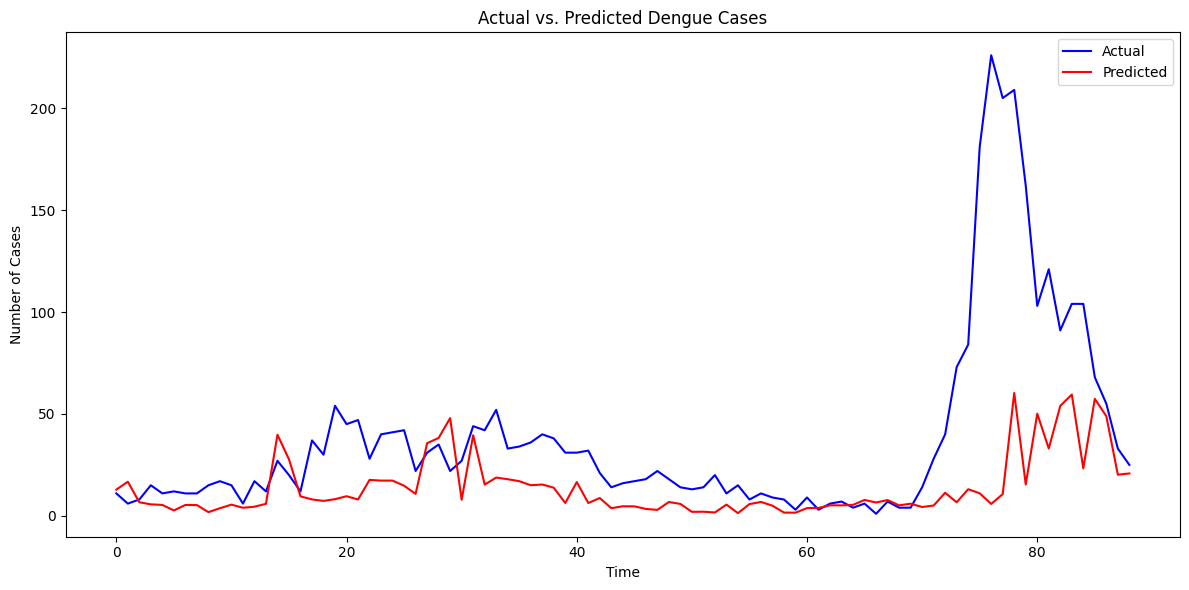


Training SVR Model...

Evaluating SVR Model...
Mean Squared Error (MSE): 898.0991625575706
Root Mean Squared Error (RMSE): 29.968302630572367
Mean Absolute Error (MAE): 15.34580087509108


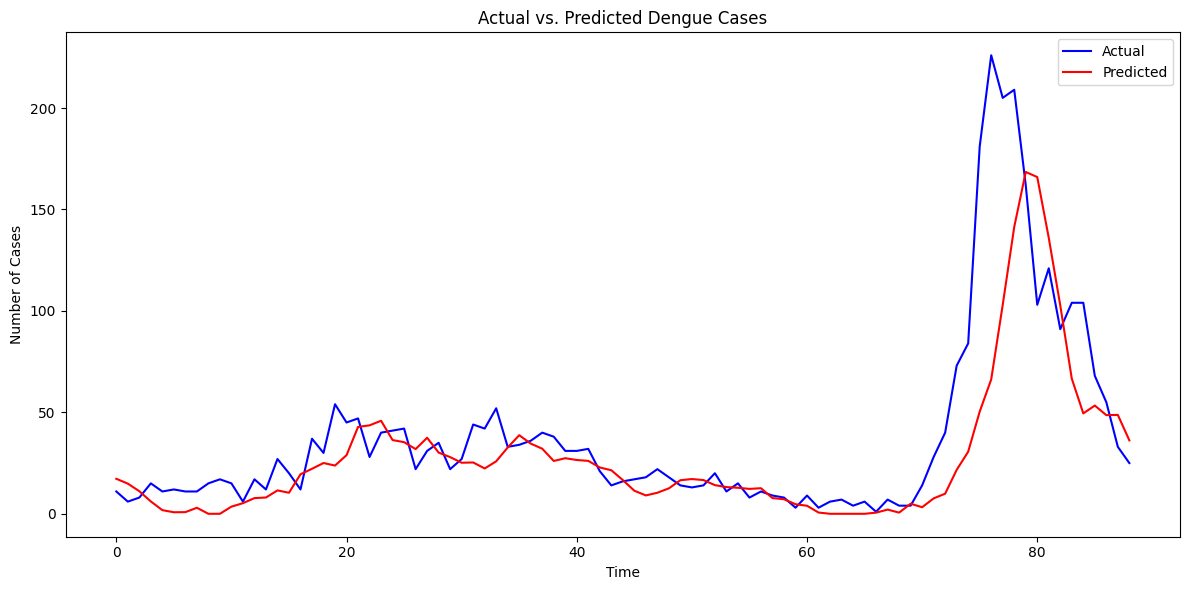


Training ANN Model...
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0431 - val_loss: 0.0306
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.0187
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0165
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0126
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0103
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0113
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0126
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0095
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0087
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0113
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0107
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━

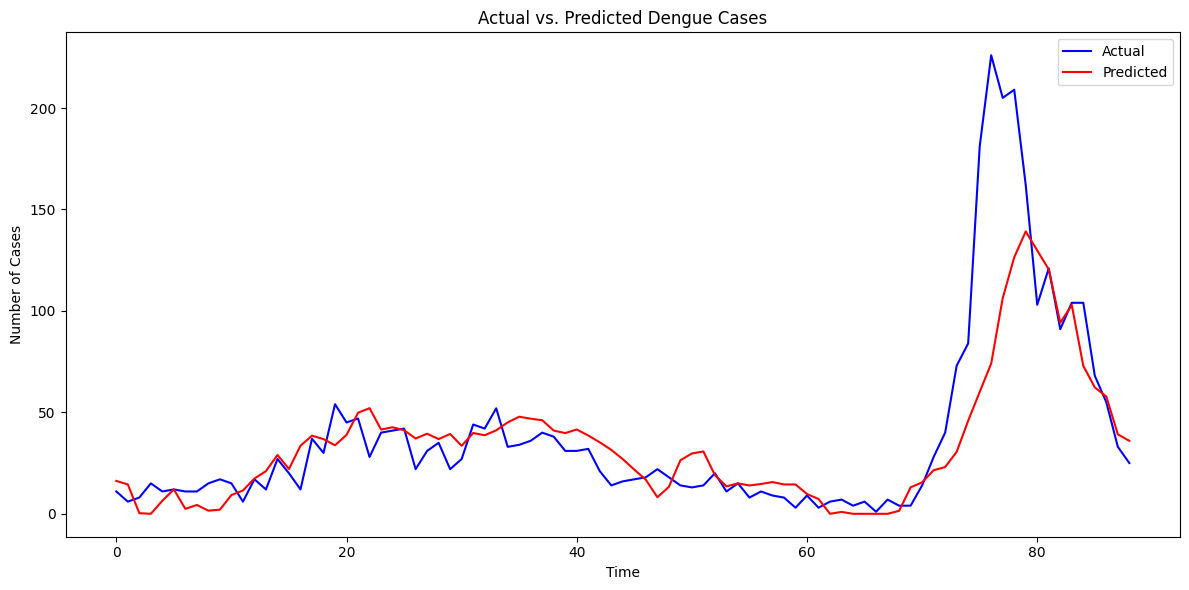


Training XGBoost Model...

Evaluating XGBoost Model...
Mean Squared Error (MSE): 759.4290630833843
Root Mean Squared Error (RMSE): 27.557740529357343
Mean Absolute Error (MAE): 18.874938013848293


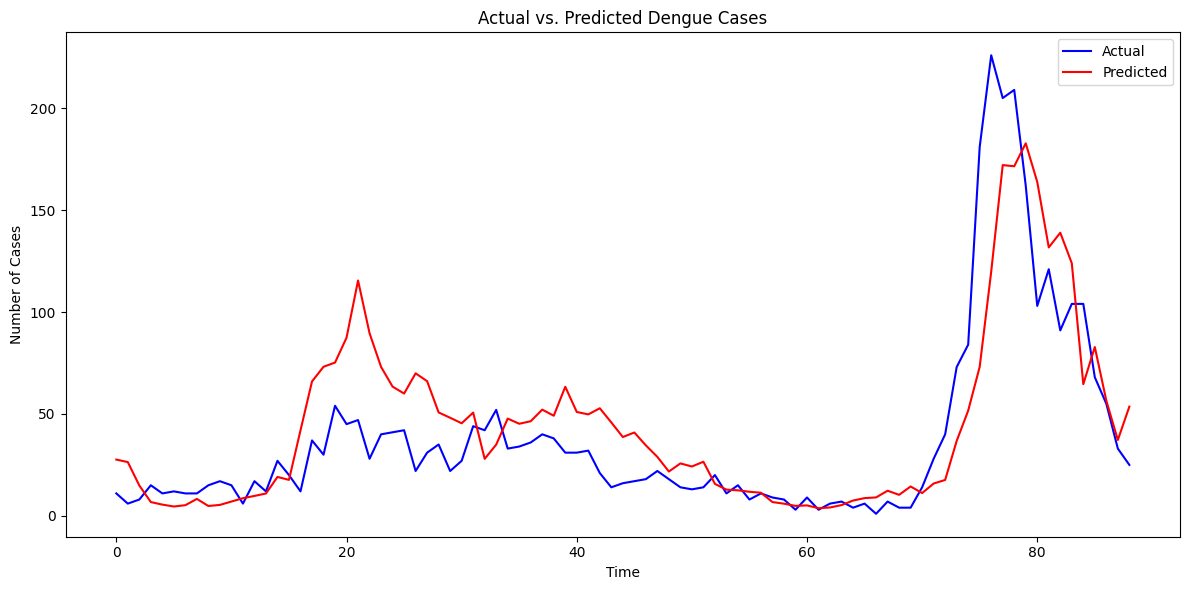


Training Linear Regression Model...

Evaluating Linear Regression Model...
Mean Squared Error (MSE): 874.2463575449317
Root Mean Squared Error (RMSE): 29.567657288749334
Mean Absolute Error (MAE): 16.372472779870073


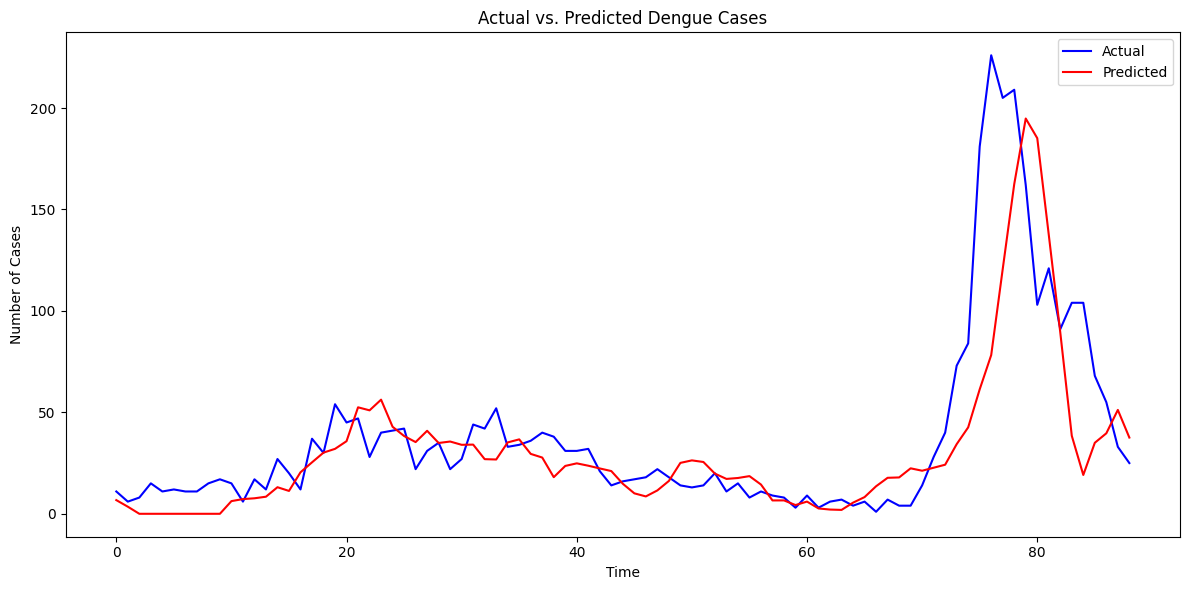


Training Random Forest Model...

Evaluating Random Forest Model...
Mean Squared Error (MSE): 645.5732786516852
Root Mean Squared Error (RMSE): 25.408134104095193
Mean Absolute Error (MAE): 16.726741573033706


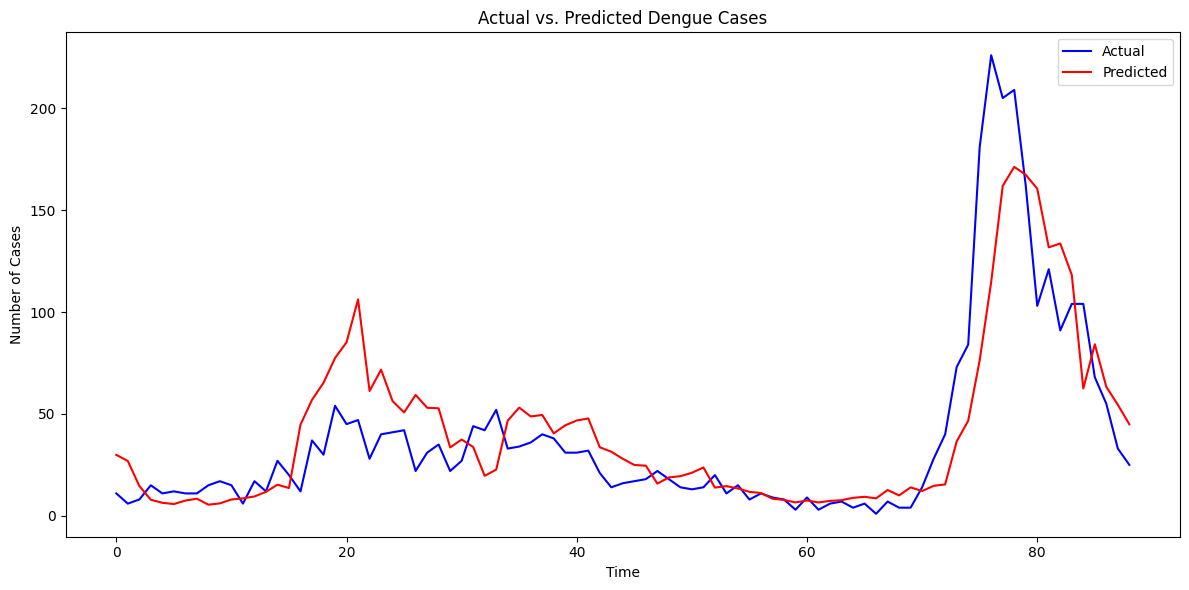


 MODEL COMPARISONS 


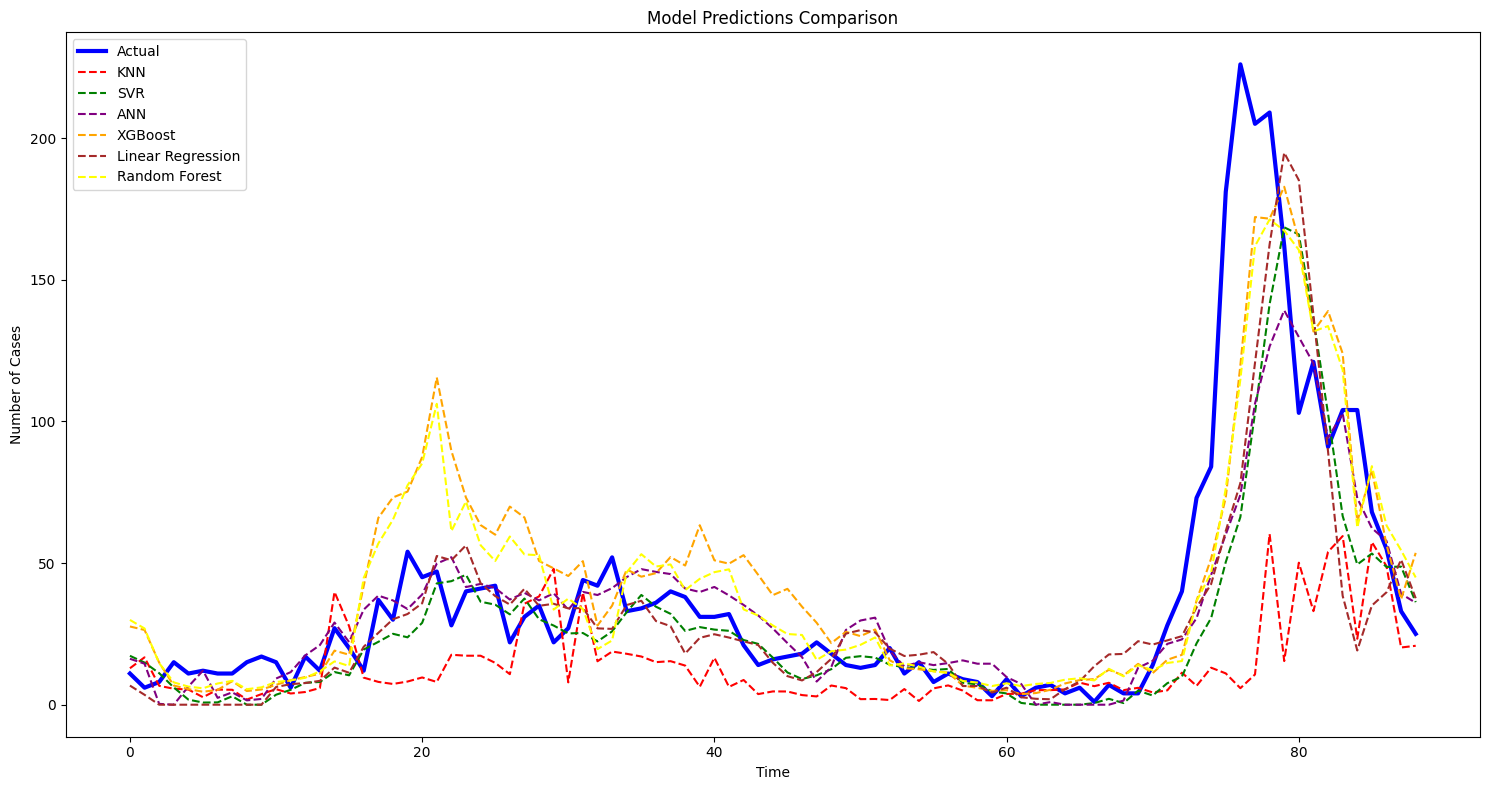

In [ ]:
def main():
    """
    Main workflow for the Dengue case prediction project with various models.
    """
    # Step 1: Load and preprocess data
    file_path = '/content/drive/MyDrive/datasets/denguedash_dataset.csv'
    df = load_and_preprocess_data(file_path)

    # Step 2: Apply moving averages
    columns_to_smooth = ['Rainfall', 'Temperature', 'Humidity', 'Cases']
    window_sizes = [3, 7, 14]
    df_ma = apply_moving_average(df, columns_to_smooth, window_sizes)
    df_ma = df_ma.dropna()  # Drop rows with NaN values

    # Step 3: Define features and target
    feature_columns = define_feature_columns()
    X = df_ma[feature_columns]
    y = df_ma['Cases']

    # Step 4: Normalize features and target
    X_normalized, y_normalized, scaler_features, scaler_target = normalize_data(X, y)

    # Step 5: Split data into training and testing sets
    X_train, X_test, y_train, y_test = split_data(X_normalized, y_normalized)

    # Dictionary to store results for each model
    model_results = {}

    # Train and evaluate the KNN model
    print("\nTraining KNN Model...")
    knn_model = train_knn_model(X_train, y_train)
    print("\nEvaluating KNN Model...")
    knn_results = evaluate_and_display_model(knn_model, X_test, y_test, scaler_target)
    model_results['KNN'] = knn_results['Predicted']

    # Train and evaluate the SVR model
    print("\nTraining SVR Model...")
    svr_model = train_svr_model(X_train, y_train)
    print("\nEvaluating SVR Model...")
    svr_results = evaluate_and_display_model(svr_model, X_test, y_test, scaler_target)
    model_results['SVR'] = svr_results['Predicted']

    # Train and evaluate the ANN model
    print("\nTraining ANN Model...")
    ann_model, ann_history = train_ann_model(X_train, y_train, X_test, y_test)
    print("\nEvaluating ANN Model...")
    ann_results = evaluate_and_display_model(ann_model, X_test, y_test, scaler_target)
    model_results['ANN'] = ann_results['Predicted']

    # Train and evaluate the XGBoost model
    print("\nTraining XGBoost Model...")
    xgboost_model = train_xgboost_model(X_train, y_train)
    print("\nEvaluating XGBoost Model...")
    xgboost_results = evaluate_and_display_model(xgboost_model, X_test, y_test, scaler_target)
    model_results['XGBoost'] = xgboost_results['Predicted']

    # Train and evaluate the Linear Regression model
    print("\nTraining Linear Regression Model...")
    linear_model = train_linear_model(X_train, y_train)
    print("\nEvaluating Linear Regression Model...")
    linear_results = evaluate_and_display_model(linear_model, X_test, y_test, scaler_target)
    model_results['Linear Regression'] = linear_results['Predicted']

    # Train and evaluate the Random Forest model
    print("\nTraining Random Forest Model...")
    rf_model = train_random_forest_model(X_train, y_train)
    print("\nEvaluating Random Forest Model...")
    rf_results = evaluate_and_display_model(rf_model, X_test, y_test, scaler_target)
    model_results['Random Forest'] = rf_results['Predicted']

    # Add the actual values to the model_results for plotting
    model_results['Actual'] = knn_results['Actual']

    print("\n MODEL COMPARISONS ")

    # Plot the comparative model predictions
    plot_model_comparisons(model_results)

if __name__ == "__main__":
    main()